# Eval the results of Flan T5 base

In [1]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )


In [3]:

# load
model = 'flan-t5-base'

# load results
zero_shot = pd.read_csv(f"../zero-shot/data/{model}.csv")
zero_shot_with_system = pd.read_csv(
    f"../zero-shot-system_prompt/data/{model}.csv")
zero_shot_cot = pd.read_csv(f"../zero-shot-cot/data/{model}.csv")
two_shot = pd.read_csv(f"../2-shot/data/{model}.csv")
four_shot = pd.read_csv(f"../4-shot/data/{model}.csv")


#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
zero_shot = zero_shot.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
zero_shot_with_system = zero_shot_with_system.merge(pool['text'], on='text',
                                                    how='left',
                                                    indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
zero_shot_cot = zero_shot_cot.merge(pool['text'], on='text', how='left',
                                    indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
two_shot = two_shot.merge(pool['text'], on='text', how='left',
                          indicator=True).query('_merge == "left_only"').drop(
    '_merge', axis=1)
four_shot = four_shot.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)



#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge = babe at begin
df_merge_all_runs = df_babe

# Zero shot

In [4]:
_soft_parse(zero_shot, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
zero_shot.query("label == '?'")

,text,response,raw_data,query,label


In [5]:
# preprocessing

In [6]:
zero_shot = zero_shot.rename(columns={"label": "0_shot_label"})
zero_shot['0_shot_label'] = zero_shot['0_shot_label'].replace('BIASED', 1)
zero_shot['0_shot_label'] = zero_shot['0_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(zero_shot[zero_shot['0_shot_label'] != '?'][['text', '0_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot[zero_shot['0_shot_label'] != '?'][['text', '0_shot_label']], on='text')
ground_truth = df_merge['label']
zero_shot_label = df_merge['0_shot_label']

In [7]:
print("F1-Score with TODO: ", f1_score(ground_truth, zero_shot_label))
print("Precision with TODO: ",
      precision_score(ground_truth, zero_shot_label))
print("Recall with TODO: ",
      recall_score(ground_truth, zero_shot_label))
print("Accuracy with TODO: ",
      accuracy_score(ground_truth, zero_shot_label))

F1-Score with TODO:  0.6531899109792285
Precision with TODO:  0.517788885621876
Recall with TODO:  0.8844801607232546
Accuracy with TODO:  0.53494155682666


# zero shot with system prompt

In [8]:
zero_shot_with_system.query("label == '?'")

,text,response,raw_data,query,label


In [10]:
zero_shot_with_system = zero_shot_with_system.rename(
    columns={"label": "0_shot_with_system_label"})
zero_shot_with_system['0_shot_with_system_label'] = zero_shot_with_system[
    '0_shot_with_system_label'].replace('BIASED', 1)
zero_shot_with_system['0_shot_with_system_label'] = zero_shot_with_system[
    '0_shot_with_system_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(zero_shot_with_system[zero_shot_with_system['0_shot_with_system_label'] != '?'][['text', '0_shot_with_system_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot_with_system[zero_shot_with_system['0_shot_with_system_label'] != '?'][['text', '0_shot_with_system_label']], on='text')
 
ground_truth = df_merge['label']
zero_shot_with_system_label = df_merge['0_shot_with_system_label']

In [11]:
print("F1-Score with TODO with System Prompt: ",
      f1_score(ground_truth, zero_shot_with_system_label))
print("Precision with TODO with System Prompt: ",
      precision_score(ground_truth, zero_shot_with_system_label))
print("Recall with TODO with System Prompt: ",
      recall_score(ground_truth, zero_shot_with_system_label))
print("Accuracy with TODO with System Prompt: ",
      accuracy_score(ground_truth, zero_shot_with_system_label))

F1-Score with TODO with System Prompt:  0.6612755008270539
Precision with TODO with System Prompt:  0.5214492753623189
Recall with TODO with System Prompt:  0.903566047212456
Accuracy with TODO with System Prompt:  0.54165630440189


# zero shot CoT

In [12]:
zero_shot_cot.query("label == '?'")

,text,response,raw_data,query,label


In [33]:
# preprocessing

In [13]:
zero_shot_cot = zero_shot_cot.rename(columns={"label": "0_shot_cot_label"})
zero_shot_cot['0_shot_cot_label'] = zero_shot_cot['0_shot_cot_label'].replace(
    'BIASED', 1)
zero_shot_cot['0_shot_cot_label'] = zero_shot_cot['0_shot_cot_label'].replace(
    'NOT BIASED', 0)
df_merge = df_babe.merge(zero_shot_cot[zero_shot_cot['0_shot_cot_label'] != '?'][['text', '0_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot_cot[zero_shot_cot['0_shot_cot_label'] != '?'][['text', '0_shot_cot_label']], on='text')
 
ground_truth = df_merge['label']
zero_shot_cot_label = df_merge['0_shot_cot_label']

In [14]:
print("F1-Score with TODO with CoT: ",
      f1_score(ground_truth, zero_shot_cot_label))
print("Precision with TODO with CoT: ",
      precision_score(ground_truth, zero_shot_cot_label))
print("Recall with TODO with CoT: ",
      recall_score(ground_truth, zero_shot_cot_label))
print("Accuracy with TODO with CoT: ",
      accuracy_score(ground_truth, zero_shot_cot_label))

F1-Score with TODO with CoT:  0.6601239669421488
Precision with TODO with CoT:  0.5022268797484936
Recall with TODO with CoT:  0.9628327473631341
Accuracy with TODO with CoT:  0.5090773439442925


# 2-shot

In [36]:
two_shot.query("label == '?'")

,text,response,raw_data,query,label


In [37]:
# preprocessing

In [15]:
two_shot = two_shot.rename(columns={"label": "2_shot_label"})
two_shot['2_shot_label'] = two_shot['2_shot_label'].replace('BIASED', 1)
two_shot['2_shot_label'] = two_shot['2_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(two_shot[two_shot['2_shot_label'] != '?'][['text', '2_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(two_shot[two_shot['2_shot_label'] != '?'][['text', '2_shot_label']], on='text')
ground_truth = df_merge['label']
two_shot_label = df_merge['2_shot_label']

In [16]:
print("F1-Score with TODO with (2 shot): ",
      f1_score(ground_truth, two_shot_label))
print("Precision with TODO with (2 shot): ",
      precision_score(ground_truth, two_shot_label))
print("Recall with TODO with (2 shot): ",
      recall_score(ground_truth, two_shot_label))
print("Accuracy with TODO with (2 shot): ",
      accuracy_score(ground_truth, two_shot_label))

F1-Score with TODO with (2 shot):  0.6629908103592314
Precision with TODO with (2 shot):  0.49674511767651475
Recall with TODO with (2 shot):  0.9964841788046208
Accuracy with TODO with (2 shot):  0.49838348669485205


# 4-shot

In [40]:
four_shot.query("label == '?'")

,text,response,raw_data,query,label


In [41]:
# preprocessing

In [17]:
four_shot = four_shot.rename(columns={"label": "4_shot_label"})
four_shot['4_shot_label'] = four_shot['4_shot_label'].replace('BIASED', 1)
four_shot['4_shot_label'] = four_shot['4_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(four_shot[four_shot['4_shot_label'] != '?'][['text', '4_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(four_shot[four_shot['4_shot_label'] != '?'][['text', '4_shot_label']], on='text')
ground_truth = df_merge['label']
four_shot_label = df_merge['4_shot_label']

In [18]:
print("F1-Score with TODO with (4 shot): ",
      f1_score(ground_truth, four_shot_label))
print("Precision with TODO with (4 shot): ",
      precision_score(ground_truth, four_shot_label))
print("Recall with TODO with (4 shot): ",
      recall_score(ground_truth, four_shot_label))
print("Accuracy with TODO with (4 shot): ",
      accuracy_score(ground_truth, four_shot_label))

F1-Score with TODO with (4 shot):  0.6629889669007022
Precision with TODO with (4 shot):  0.49686795289401153
Recall with TODO with (4 shot):  0.9959819186338523
Accuracy with TODO with (4 shot):  0.4986321810494902


# Comparison and plots

KeyError: '0_shot_label'

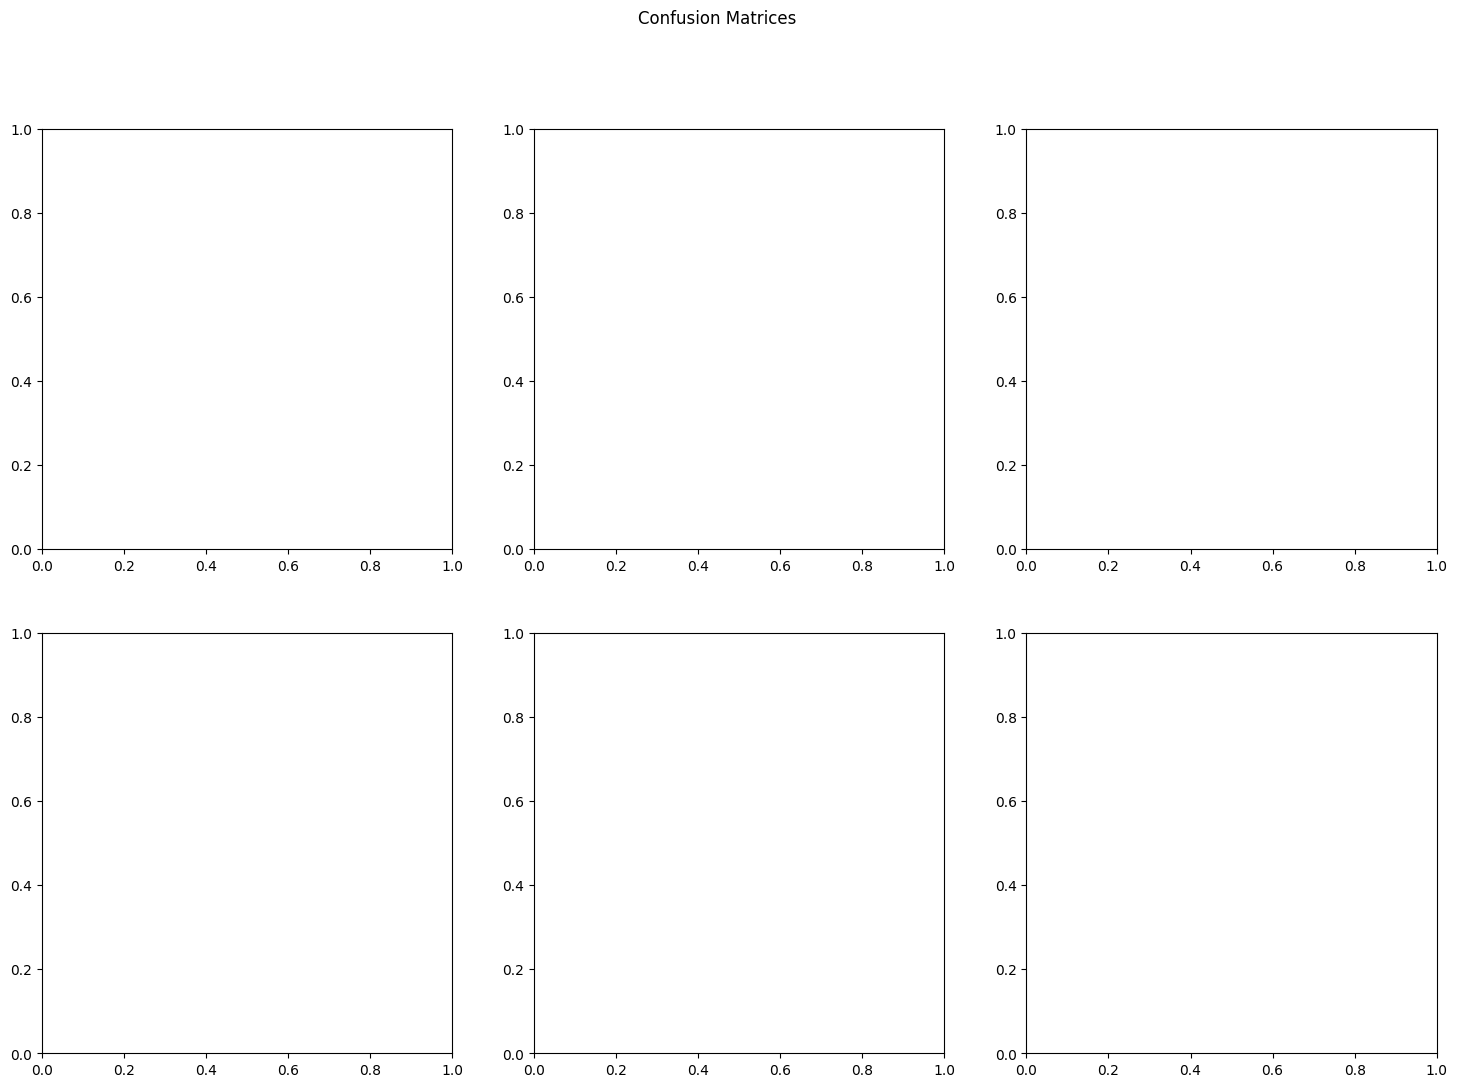

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}']
    true_labels = df[f'{true_labels_column}']

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)


    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices')

# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge, 'label', '0_shot_label', '0_shot')
plot_confusion_matrix(axes[0, 1], df_merge, 'label',
                      '0_shot_with_system_label', '0_shot_with_system')
plot_confusion_matrix(axes[0, 2], df_merge, 'label', '0_shot_cot_label',
                      '0_shot_cot')
plot_confusion_matrix(axes[1, 0], df_merge, 'label', '2_shot_label', '2_shot')
plot_confusion_matrix(axes[1, 1], df_merge, 'label', '4_shot_label', '4_shot')
plot_confusion_matrix(axes[1, 2], df_merge, 'label', '8_shot_label', '8_shot')

plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in model

In [ ]:
import krippendorff

runs = ['0_shot_label', '0_shot_with_system_label', '0_shot_cot_label',
        '2_shot_label', '4_shot_label', '8_shot_label']


def compute_krippendorff_alpha(df, predicted_columns):
    pred_map = {}
    for run in predicted_columns:
        predicted_labels = df[run]
        pred_map[run] = predicted_labels

    # Check if there is variability in the ratings
    unique_labels_counts = df[predicted_columns].nunique(axis=1)
    if unique_labels_counts.max() == 1:
        # All ratings are the same, return a special value or handle accordingly
        return 0

    reliability_data = df[predicted_columns].values.tolist()

    # Calculate Krippendorff's alpha
    alpha = krippendorff.alpha(reliability_data=list(pred_map.values()),
                               level_of_measurement='nominal')

    return alpha


In [ ]:
alpha_value = compute_krippendorff_alpha(df_merge, runs)
print(f"Krippendorff's Alpha (all runs): {alpha_value}")

In [ ]:
import itertools

def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [ ]:
compute_krippendorff_alpha_for_k_runs(df_merge, runs, 2)